# Displaying complete deconvolution results

In [1]:
## Imports
from __future__ import print_function
from __future__ import division

#%matplotlib notebook
from spike.Interactive.FTICR_INTER import MR, MR_interact

from bokeh.io import show,output_notebook
output_notebook()

try:
    from importlib import reload  # python 3
except:
    pass # python 2

import spike
from spike import FTICR

#%matplotlib notebook

import sys
sys.path.append('/home/laura/Desktop/isotopic-deconv-basic-code')
import os
try:
    from importlib import reload
except:
    pass
import numpy as np
import scipy
from scipy.signal import fftconvolve
import matplotlib.mlab as mlab
from isotope import isotopes as iso
iso.THRESHOLD = 1E-5 # devrait être 1E-5 ! mais plus rapide
from isotope.proteins import averagine
from isotope import Fstore
import Deconvolution_fast as dec
reload(dec)
import isotopic_analysis as ia
reload(ia)
import tools_2DFTICR_Data as tools2D
reload(tools2D)
import PDS
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy.optimize import curve_fit
import numpy as np
from matplotlib import pyplot as plt
from itertools import cycle

dec.memoize_clear()

## Loading dataset
data_name = "/home/laura/Desktop/isotopic-deconv-basic-code_local/Data/BSA_2_sane200_mr.msh5"


          SPIKE
    Version     : 0.99.14
    Date        : 02-01-2020
    Revision Id : 451
*** zoom3D not loaded ***
plugins loaded:
Bruker_NMR_FT,  Bucketing,  FTMS_calib,  Fitter,  Integrate,  Linear_prediction,  PALMA,  Peaks,  apmin,  bcorr,  bokeh_display,  fastclean,  gaussenh,  pg_sane,  rem_ridge,  sane,  sg,  test,  urQRd,  wavelet, 

spike.plugins.report() for a short description of each plugins
spike.plugins.report('module_name') for complete documentation on one plugin


Loading BokehJS ...

***Running on CPU***
***Running on CPU***
*** memoize cleared !!! ***


In [2]:
d = FTICR.FTICRData(name=data_name, mode="onfile") #Mode onfile avoid taking too much space on the computer memory

#d._absmax = 76601098.15623298

In [3]:
threshold = 2E6
threshold

2000000.0

In [4]:
zm = (300,1200,150,1200)

In [5]:
d.pp(threshold=threshold, zoom=tools2D.mztoi(d,zm))

########## in peaks2d 
zoom  (566.2743906756225, 3396.373759578305, 32202.132466346666, 257617.05973077333)
z1lo, z1up, z2lo, z2up  566 3397 32202 257618
PP: 11616 detected


2D data-set
Axis F1 :FT-ICR report axis at 666.705812 kHz,  4096 real points,  from physical mz =  253.134   to m/z = 3000.000  R max (M=400) = 2830
Axis F2: FT-ICR report axis at 1250.000000 kHz,  262144 real points,  from physical mz =  147.410   to m/z = 3000.000  R max (M=400) = 96606
data-set is real

In [ ]:
d.unit = 'm/z'
fig = plt.figure(figsize=(18,12))
ax = fig.add_subplot(111)
ax.set_xlabel('m/z')
ax.set_ylabel('m/z')
d.display(scale=5, zoom=zm, figure=ax)

In [ ]:
d.unit = 'm/z'
#d.display(scale=5, zoom=(620,700,300,1200))
fig = plt.figure(figsize=(18,12))
ax = fig.add_subplot(111)
ax.set_xlabel('m/z')
ax.set_ylabel('m/z')
d.display_peaks(zoom=zm,markersize=3)

In [6]:
print("With the classical peak picking over the 2D, there are:",len(d.peaks),"peaks.")

With the classical peak picking over the 2D, there are: 11616 peaks.


In [9]:
resdata = "/home/laura/BSA2_sane200_20200113_1024x256_DeconvResults"

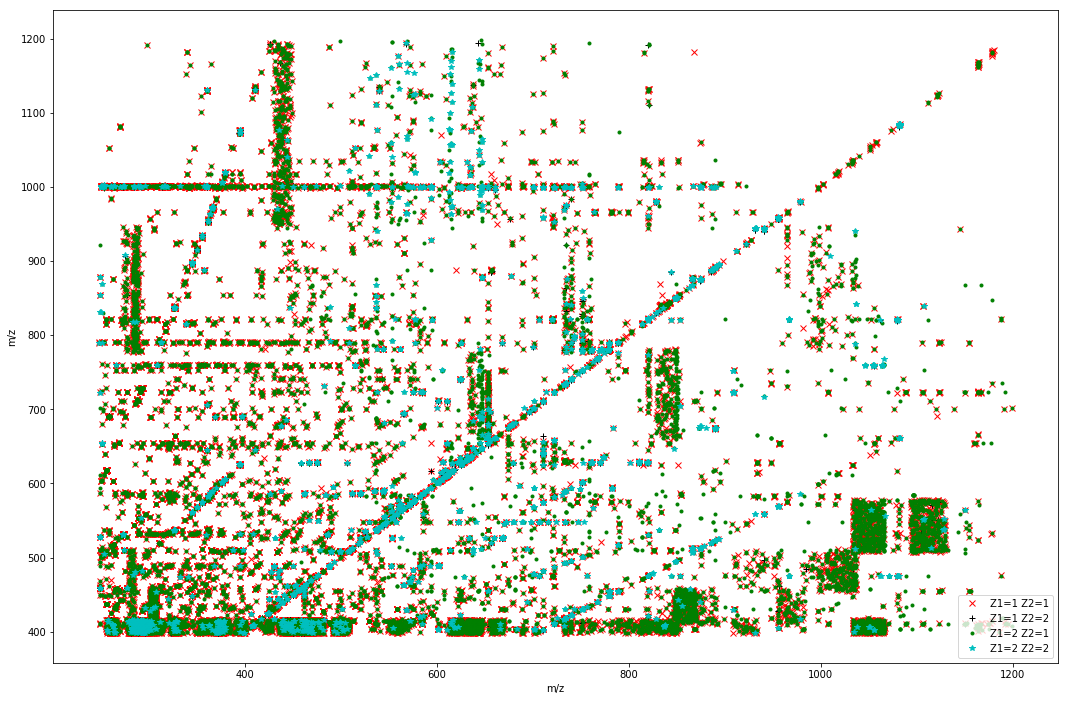

In [10]:
cycol = cycle('rkgc')
cymark = cycle('x+.*')
axeZ1 = [1,2]
axeZ2 = [1,2]
fig = plt.figure(figsize=(18, 12))
ax = fig.add_subplot(111)
ax.set_xlabel('m/z')
ax.set_ylabel('m/z')
#data_name = "Big_YeastExtract_20190612_3x1024x256_DeconvResults"
with open(os.path.join(resdata,"full_deconv_pks_list.txt")) as json_file:  
    full_pks_dic = json.load(json_file)

final_pk_dic = {}
for z1 in axeZ1:
    for z2 in axeZ2:
            plt.plot(full_pks_dic["pks_{0}{1}_f2".format(z1,z2)],full_pks_dic["pks_{0}{1}_f1".format(z1,z2)],linestyle="None",marker=next(cymark),color=next(cycol), label="Z1={0} Z2={1}".format(z1,z2))  
            final_pk_dic["pks_{0}{1}_f2".format(z1,z2)] = full_pks_dic["pks_{0}{1}_f2".format(z1,z2)]
            final_pk_dic["pks_{0}{1}_f1".format(z1,z2)] = full_pks_dic["pks_{0}{1}_f1".format(z1,z2)]
plt.legend(loc='lower right')
plt.show()

In [11]:
print("Before cleaning of impossible cases, there are:",len(full_pks_dic["pks_11_f1"]+full_pks_dic["pks_12_f1"]+full_pks_dic["pks_21_f1"]+full_pks_dic["pks_22_f1"]),"peaks.")

Before cleaning of impossible cases, there are: 41995 peaks.


In [14]:
%matplotlib notebook

<IPython.core.display.Javascript object>


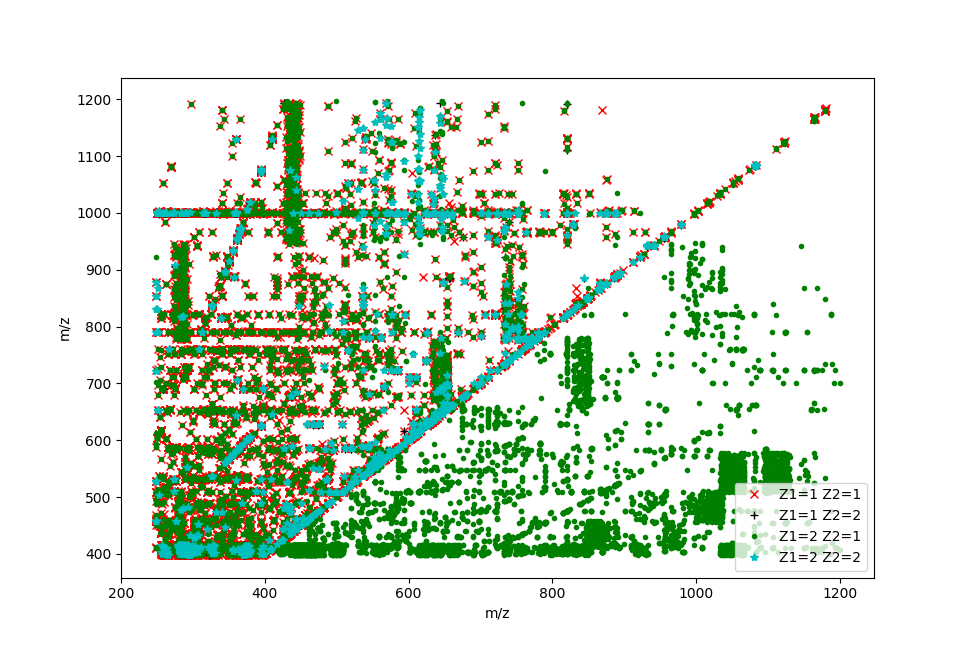

In [15]:
cycol = cycle('rkgc')
cymark = cycle('x+.*')
axeZ1 = [1,2]
axeZ2 = [1,2]
fig = plt.figure(figsize=(18, 12))
ax = fig.add_subplot(111)
ax.set_xlabel('m/z')
ax.set_ylabel('m/z')
#data_name = "Big_YeastExtract_20190612_3x1024x256_DeconvResults"
with open(os.path.join(resdata,"full_deconv_pks_list.txt")) as json_file:  
    full_pks_dic = json.load(json_file)

final_pk_dic = {}
for z1 in axeZ1:
    for z2 in axeZ2:
        if (z1,z2) != (2,1):
            X = []
            Y = []
            for x,y in zip(full_pks_dic["pks_{0}{1}_f2".format(z1,z2)],full_pks_dic["pks_{0}{1}_f1".format(z1,z2)]):
                if x <= y:
                    X.append(x)
                    Y.append(y)
            final_pk_dic["pks_{0}{1}_f2".format(z1,z2)] = X
            final_pk_dic["pks_{0}{1}_f1".format(z1,z2)] = Y
            plt.plot(X,Y,linestyle="None",marker=next(cymark),color=next(cycol), label="Z1={0} Z2={1}".format(z1,z2))
        else:
            plt.plot(full_pks_dic["pks_{0}{1}_f2".format(z1,z2)],full_pks_dic["pks_{0}{1}_f1".format(z1,z2)],linestyle="None",marker=next(cymark),color=next(cycol), label="Z1={0} Z2={1}".format(z1,z2))  
            final_pk_dic["pks_{0}{1}_f2".format(z1,z2)] = full_pks_dic["pks_{0}{1}_f2".format(z1,z2)]
            final_pk_dic["pks_{0}{1}_f1".format(z1,z2)] = full_pks_dic["pks_{0}{1}_f1".format(z1,z2)]
plt.legend(loc='lower right')
plt.show()

In [13]:
print("After cleaning wrong (z1,z2) pairs, there are:",len(final_pk_dic["pks_11_f2"]+final_pk_dic["pks_12_f2"]+final_pk_dic["pks_21_f2"]+final_pk_dic["pks_22_f2"]),"peaks.")

After cleaning wrong (z1,z2) pairs, there are: 34917 peaks.
